In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import preprocess

import torch
from torch import nn
from torch import optim
import torch.utils.data as data_utils
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Global Variables

In [3]:
random_state = 1048576
target = 'loan_status'
cat_features = [
    'person_home_ownership', 
    'loan_intent', 
    'loan_grade', 
    'cb_person_default_on_file'
]

num_features = [
    'person_age', 
    'person_income', 
    'person_emp_length', 
    'loan_amnt', 
    'loan_int_rate', 
    'loan_percent_income', 
    'cb_person_cred_hist_length'
]

# Data Loading and Preprocessing

In [20]:
X_train, X_test, y_train, y_test = preprocess.DataImport.get_train_test('train.csv', index_col=0, target=target, random_state=random_state, verbose=1)
X_train, y_train = preprocess.Outliers.remove_outliers(X_train, y_train, verbose=1)
encoder = preprocess.CategoryEncoder(cat_features=cat_features, method='one_hot')
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
features = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

print(f'Target distribution before oversampling: (0: {round(y_train.sum() / y_train.size * 100, 2)}%, 1: {round((1 - y_train.sum() / y_train.size) * 100, 2)}%)')
oversampler = RandomOverSampler(random_state=random_state)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
print(f'X_train shape after oversampling: {X_train.shape}; y_train shape after oversampling: {X_train.shape}')
print(f'Target distribution after oversampling: (0: {round(y_train.sum() / y_train.size * 100, 2)}%, 1: {round((1 - y_train.sum() / y_train.size) * 100, 2)}%)')

Shape of X_train is: (52780, 11); shape of y_train is: (52780,)
Shape of X_test is: (5865, 11); shape of y_test is: (5865,)
New shape of X_train is: (52639, 11); New shape of y_train is: (52639,)
Target distribution before oversampling: (0: 14.22%, 1: 85.78%)
X_train shape after oversampling: (90312, 26); y_train shape after oversampling: (90312, 26)
Target distribution after oversampling: (0: 50.0%, 1: 50.0%)


In [28]:
type(nn.BCELoss())

torch.nn.modules.loss.BCELoss

# Model building

In [99]:
# Define the neural network model
class BinaryClassificationNN(nn.Module):
    def __init__(self, shape: np.ndarray):
        super(BinaryClassificationNN, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(in_features=shape[1], out_features=32)  
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=8)
        self.fc4 = nn.Linear(in_features=8, out_features=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Sigmoid for probability output
        self.sigmoid = nn.Sigmoid()
    
        # Initialize weights
        self.init_weights()  # Custom weight initialization
    
    def init_weights(self):
        # Initialize weights with Xavier (Glorot) initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        
        # Optionally, initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
    

    def forward(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.relu(self.fc3(X))
        X = self.sigmoid(self.fc4(X))  # Sigmoid for binary classification
        return X
    
    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray, num_epochs: int = 10, batch_size: int = 32, shuffle: bool = True, learning_rate: float = 0.01, weight_decay: float = 1e-3, cv: int = 0, criterion: torch.nn.modules.loss = nn.BCELoss(), verbose: int = 1):
        # Initialize optimizer and loss_list
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.loss_list = []
        
        # Initialize data_laoder
        X = X.copy()
        y = y.copy()
        X = torch.tensor(X.values, dtype=torch.float32)  
        y = torch.tensor(y.values, dtype=torch.float32)
        data_tensor = data_utils.TensorDataset(X, y)
        data_loader = data_utils.DataLoader(dataset = data_tensor, batch_size=batch_size, shuffle=shuffle)

        for epoch in range(num_epochs):  # Training loop
            batch_loss = []
            for batch_idx, (inputs, labels) in enumerate(data_loader): # For each batch                
                # Forward pass
                outputs = self(inputs)
                outputs = torch.squeeze(outputs)
                
                # Compute the loss
                loss = criterion(outputs, labels)
                
                # Backpropagation and optimization
                optimizer.zero_grad()  # Clear previous gradients
                loss.backward() # Backpropagate
                optimizer.step() # Update weights

                batch_loss.append(loss.item())

                if verbose > 1 and batch_idx % (X.shape[0] // batch_size // 10) == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}") # Printing loss
                elif verbose == 1 and batch_idx == len(data_loader) - 1:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {round(sum(batch_loss) / len(batch_loss), 4)}") # Printing loss

            # Store the loss value for this epoch
            self.loss_list.append(round(sum(batch_loss) / len(batch_loss), 4))
        return 
    

    def predict(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        inputs = torch.tensor(X.values, dtype=torch.float32)
        return self.forward(inputs)





In [103]:
# Create an instance of the model
torch.manual_seed(random_state)
model = BinaryClassificationNN(X_train.shape)

loss_hist = {}
model = {}

torch.manual_seed(random_state)
model[32] = BinaryClassificationNN(X_train.shape)
model[32].fit(X_train, y_train, learning_rate=0.001, num_epochs=20, batch_size=32,verbose=1)
loss_hist[32] = model[32].loss_list

torch.manual_seed(random_state)
model[64] = BinaryClassificationNN(X_train.shape)
model[64].fit(X_train, y_train, learning_rate=0.001, num_epochs=20, batch_size=64, verbose=1)
loss_hist[64] = model[64].loss_list

Epoch [1/20], Average Loss: 0.3578
Epoch [2/20], Average Loss: 0.3243
Epoch [3/20], Average Loss: 0.3188
Epoch [4/20], Average Loss: 0.3152
Epoch [5/20], Average Loss: 0.3129
Epoch [6/20], Average Loss: 0.3114
Epoch [7/20], Average Loss: 0.3098
Epoch [8/20], Average Loss: 0.3086
Epoch [9/20], Average Loss: 0.3079
Epoch [10/20], Average Loss: 0.3067
Epoch [11/20], Average Loss: 0.3059
Epoch [12/20], Average Loss: 0.305
Epoch [13/20], Average Loss: 0.3042
Epoch [14/20], Average Loss: 0.3032
Epoch [15/20], Average Loss: 0.3025
Epoch [16/20], Average Loss: 0.302
Epoch [17/20], Average Loss: 0.3016
Epoch [18/20], Average Loss: 0.301
Epoch [19/20], Average Loss: 0.3002
Epoch [20/20], Average Loss: 0.3002
Epoch [1/20], Average Loss: 0.3704
Epoch [2/20], Average Loss: 0.3274
Epoch [3/20], Average Loss: 0.3205
Epoch [4/20], Average Loss: 0.3164
Epoch [5/20], Average Loss: 0.3137
Epoch [6/20], Average Loss: 0.3118
Epoch [7/20], Average Loss: 0.31
Epoch [8/20], Average Loss: 0.3087
Epoch [9/20], 

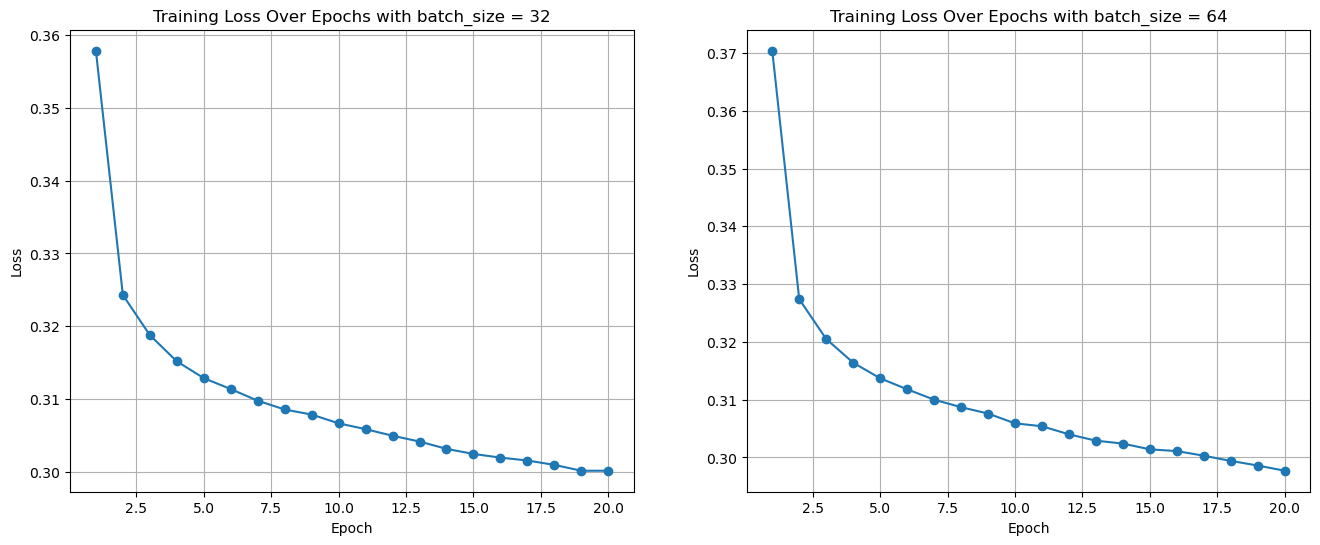

In [109]:
num_epochs = 20

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(8 * 2, 6 * 1))
axes[0].plot(range(1, num_epochs+1), loss_hist[32], marker='o')
axes[0].set_title('Training Loss Over Epochs with batch_size = 32')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(range(1, num_epochs+1), loss_hist[64], marker='o')
axes[1].set_title('Training Loss Over Epochs with batch_size = 64')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

plt.show()

In [104]:
loss_hist

{32: [0.3578,
  0.3243,
  0.3188,
  0.3152,
  0.3129,
  0.3114,
  0.3098,
  0.3086,
  0.3079,
  0.3067,
  0.3059,
  0.305,
  0.3042,
  0.3032,
  0.3025,
  0.302,
  0.3016,
  0.301,
  0.3002,
  0.3002],
 64: [0.3704,
  0.3274,
  0.3205,
  0.3164,
  0.3137,
  0.3118,
  0.31,
  0.3087,
  0.3076,
  0.3059,
  0.3054,
  0.304,
  0.3029,
  0.3024,
  0.3014,
  0.3011,
  0.3003,
  0.2994,
  0.2986,
  0.2977]}

In [95]:
model.predict(X_train)

tensor([[0.9768],
        [0.0963],
        [0.0767],
        ...,
        [0.6901],
        [0.9976],
        [0.9967]], grad_fn=<SigmoidBackward0>)

In [96]:
print(f'Train AUC = {roc_auc_score(y_train, model.predict(X_train).detach().numpy())}')

Train AUC = 0.9450248903279332


In [97]:
print(f'Test AUC = {roc_auc_score(y_test, model.predict(X_test).detach().numpy())}')

Test AUC = 0.9296571520639196


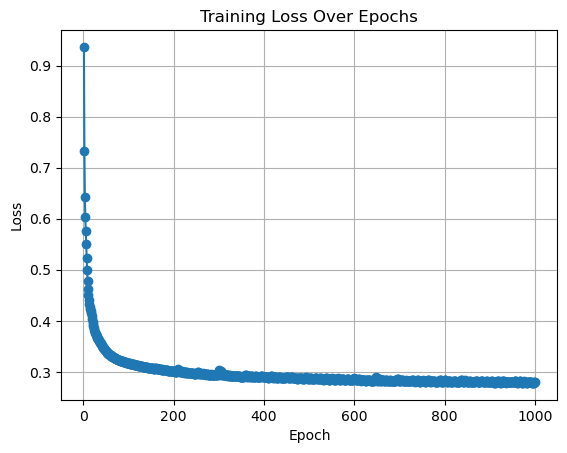

In [40]:
plt.plot(range(1, num_epochs+1), loss_list, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()